### Setup

In [1]:
# %pip install "jax[cuda12]" equinox optax optimistix treescope
%pip install jax equinox optax optimistix treescope
%load_ext autoreload
%autoreload 2

from functools import partial
import jax
import jax.numpy as jnp
import equinox as eqx
import treescope

import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
from tueplots import bundles, figsizes

plt.rcParams.update({"figure.dpi": 150})
plt.rcParams.update(figsizes.icml2024_half())
plt.rcParams.update(bundles.icml2024(family="serif"))

colors = [
    "#55b2e8",
    "#cc78a6",
    "#009e73",
    "#efe440",
    "#d65c00",
    "#0071b2",
    "#e59c00",
    "#000000",
]
plt.rc("axes", prop_cycle=cycler("color", colors))

Note: you may need to restart the kernel to use updated packages.


### Train model on MNIST

In [2]:
from mnist import mnist_data

_, _, mnist_test_images, mnist_test_labels = mnist_data()

batch_size = 1024
mnist_test_image_batch = mnist_test_images[:batch_size]
mnist_test_label_batch = mnist_test_labels[:batch_size]

# Sort by label
idx = jnp.argsort(mnist_test_label_batch.argmax(-1))
mnist_test_image_batch = mnist_test_image_batch[idx]
mnist_test_label_batch = mnist_test_label_batch[idx]

treescope.render_array(
    mnist_test_image_batch.reshape(-1, 28, 28)[:20],
    pixels_per_cell=1,
    columns=[2, 0],
    axis_labels={0: "input example", 1: "input dimension", 2: "input dimension"},
    vmax=1,
    vmin=-1,
)

<Arrayviz rendering>

In [4]:
%%time
from mnist import train_mnist

num_seeds = 2
mnist_model = train_mnist(num_seeds=num_seeds, num_epochs=30)
mnist_model

Epoch 0		train loss: 2.3 ± 0.00395	test error: 90.72%
Epoch 1		train loss: 0.227 ± 0.00112


KeyboardInterrupt: 

### Manipulations

In [4]:
from expand import scale_neurons
from expand import duplicate_neurons
from expand import add_random_zero_neurons

from asysid.utils.bmap import bmap


@partial(bmap, in_axes=(eqx.if_array(0), None))
def scale_manipulation(model, scale_factor):
    W2 = model.layers[1].weight
    W3 = model.layers[2].weight
    new_W2, new_W3 = scale_neurons(w_in=W2, w_out=W3, scale_factor=scale_factor)
    new_model = eqx.tree_at(lambda x: x.layers[1].weight, model, new_W2)
    new_model = eqx.tree_at(lambda x: x.layers[2].weight, new_model, new_W3)
    return new_model


@partial(bmap, in_axes=(eqx.if_array(0), None))
def duplicate_type_manipulation(model, duplicate_multiplier):
    W2 = model.layers[1].weight
    W3 = model.layers[2].weight
    new_W2, new_W3 = duplicate_neurons(
        w_in=W2, w_out=W3, duplicate_multiplier=duplicate_multiplier
    )
    new_model = eqx.tree_at(lambda x: x.layers[1].weight, model, new_W2)
    new_model = eqx.tree_at(lambda x: x.layers[2].weight, new_model, new_W3)
    return new_model


@partial(bmap, in_axes=(eqx.if_array(0), None, 0))
def zero_type_manipulation(model, num_units, key):
    W2 = model.layers[1].weight
    W3 = model.layers[2].weight
    new_W2, new_W3 = add_random_zero_neurons(
        w_in=W2, w_out=W3, num_zero_groups=num_units, neurons_per_group=1, key=key
    )
    new_model = eqx.tree_at(lambda x: x.layers[1].weight, model, new_W2)
    new_model = eqx.tree_at(lambda x: x.layers[2].weight, new_model, new_W3)
    return new_model


@partial(bmap, in_axes=(None, 0, None))
@partial(bmap, in_axes=(eqx.if_array(0), None, 0))
def parameter_noise_manipulation(model, noise_scale, key):
    W1 = model.layers[0].weight
    W2 = model.layers[1].weight
    W3 = model.layers[2].weight

    key = jax.random.split(key, 3)
    new_W1 = W1 + noise_scale * jax.random.normal(key[0], W1.shape)
    new_W2 = W2 + noise_scale * jax.random.normal(key[1], W2.shape)
    new_W3 = W3 + noise_scale * jax.random.normal(key[2], W3.shape)

    new_model = eqx.tree_at(lambda x: x.layers[0].weight, model, new_W1)
    new_model = eqx.tree_at(lambda x: x.layers[1].weight, new_model, new_W2)
    new_model = eqx.tree_at(lambda x: x.layers[2].weight, new_model, new_W3)
    return new_model


def accuracy(pred_y, y):
    target_class = jnp.argmax(y, axis=1)
    predicted_class = jnp.argmax(pred_y, axis=1)
    return jnp.mean(predicted_class == target_class)


@partial(bmap, in_axes=(eqx.if_array(0), None, None))
@partial(bmap, in_axes=(None, 0, None))
def gen_error_input_noise(model, noise_scale, key):
    def _forward(x):
        return model(x)

    pred_y = jax.lax.map(
        _forward,
        mnist_test_images
        + noise_scale * jax.random.normal(key, mnist_test_images.shape),
        batch_size=16,
    )

    test_error = 1 - accuracy(pred_y, mnist_test_labels)
    return test_error

### Test input noise robustness

In [5]:
key = jax.random.PRNGKey(37)
data_key, zero_key = jax.random.split(key)
noise_scales = jnp.logspace(-1, 1, num=40)

task_optimized_model_input_robustness = gen_error_input_noise(
    mnist_model, noise_scales, data_key
)
task_optimized_model_input_robustness.mean(0)

duplicated_model_input_robustness = gen_error_input_noise(
    scale_manipulation(mnist_model, 20), noise_scales, data_key
)
duplicated_model_input_robustness.mean(0)

scaled_model_input_robustness = gen_error_input_noise(
    duplicate_type_manipulation(mnist_model, 1 + 1), noise_scales, data_key
)
scaled_model_input_robustness.mean(0)

zeroed_model_input_robustness = gen_error_input_noise(
    zero_type_manipulation(
        mnist_model, 1 * 1024, jax.random.split(zero_key, num_seeds)
    ),
    noise_scales,
    data_key,
)
zeroed_model_input_robustness.mean(0)

Array([0.90540004, 0.9051    , 0.90485   , 0.9038    , 0.9034    ,
       0.90265   , 0.9029    , 0.90275   , 0.90305   , 0.90209997,
       0.90135   , 0.9008    , 0.8993    , 0.90065   , 0.89985   ,
       0.8998    , 0.90040004, 0.90075   , 0.90035   , 0.9007    ,
       0.9009    , 0.9002    , 0.89945   , 0.89995   , 0.9002    ,
       0.9007    , 0.9005    , 0.90105   , 0.9009    , 0.9012    ,
       0.90165   , 0.90225005, 0.90225   , 0.90215003, 0.90180004,
       0.90185   , 0.9015    , 0.90155   , 0.90145004, 0.90174997],      dtype=float32)

/var/folders/s6/ljwd9j450xgc_mjvgjtfd8cw0000gn/T/ipykernel_35060/2297163559.py:44: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


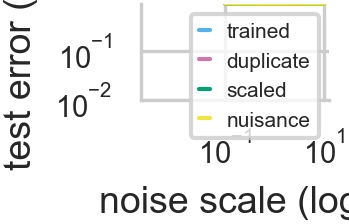

In [6]:
plt.figure(figsize=(1.6, 1.2))

# Task optimized model
mean_task = np.mean(task_optimized_model_input_robustness, axis=0)
std_task = np.std(task_optimized_model_input_robustness, axis=0)
plt.plot(noise_scales, mean_task, linewidth=1, label="trained")
plt.fill_between(noise_scales, mean_task - std_task, mean_task + std_task, alpha=0.2)

# Duplicated model
mean_dup = np.mean(duplicated_model_input_robustness, axis=0)
std_dup = np.std(duplicated_model_input_robustness, axis=0)
plt.plot(noise_scales, mean_dup, linewidth=1, label="duplicate")
plt.fill_between(noise_scales, mean_dup - std_dup, mean_dup + std_dup, alpha=0.2)

# Scaled model
mean_scaled = np.mean(scaled_model_input_robustness, axis=0)
std_scaled = np.std(scaled_model_input_robustness, axis=0)
plt.plot(noise_scales, mean_scaled, linewidth=1, label="scaled")
plt.fill_between(
    noise_scales, mean_scaled - std_scaled, mean_scaled + std_scaled, alpha=0.2
)

# Zeroed model
mean_zeroed = np.mean(zeroed_model_input_robustness, axis=0)
std_zeroed = np.std(zeroed_model_input_robustness, axis=0)
plt.plot(noise_scales, mean_zeroed, linewidth=1, label="nuisance")
plt.fill_between(
    noise_scales, mean_zeroed - std_zeroed, mean_zeroed + std_zeroed, alpha=0.2
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("noise scale (log)")
plt.ylabel("test error (log)")
plt.legend(handlelength=0.5, fontsize=5)


plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)


plt.xlim(left=2e-3)
plt.ylim(bottom=1e-2)
plt.tight_layout()
plt.savefig("input-noise.pdf", format="pdf", bbox_inches="tight", dpi=300)

### Test parameter noise robustness

In [7]:
@partial(bmap, in_axes=(eqx.if_array(0),))
def gen_error(model):
    
    def _forward(x):
        return model(x)

    pred_y = jax.lax.map(
        _forward,
        mnist_test_images,
        batch_size=16,
    )

    test_error = 1 - accuracy(pred_y, mnist_test_labels)
    return test_error


key = jax.random.PRNGKey(37)
noise_scales = jnp.logspace(-4, 0, num=40)

task_optimized_model_robustness = eqx.filter_vmap(
    gen_error, in_axes=(eqx.if_array(0),)
)(
    parameter_noise_manipulation(
        mnist_model, noise_scales, jax.random.split(key, num_seeds)
    )
)

duplicated_model_robustness = eqx.filter_vmap(gen_error, in_axes=(eqx.if_array(0),))(
    parameter_noise_manipulation(
        duplicate_type_manipulation(mnist_model, 1 + 1),
        noise_scales,
        jax.random.split(key, num_seeds),
    )
)

scaled_model_robustness = eqx.filter_vmap(gen_error, in_axes=(eqx.if_array(0),))(
    parameter_noise_manipulation(
        scale_manipulation(mnist_model, 20),
        noise_scales,
        jax.random.split(key, num_seeds),
    )
)

zeroed_model_robustness = eqx.filter_vmap(gen_error, in_axes=(eqx.if_array(0),))(
    parameter_noise_manipulation(
        zero_type_manipulation(mnist_model, 1 * 1024, jax.random.split(key, num_seeds)),
        noise_scales,
        jax.random.split(key, num_seeds),
    )
)

/var/folders/s6/ljwd9j450xgc_mjvgjtfd8cw0000gn/T/ipykernel_35060/3274919662.py:44: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


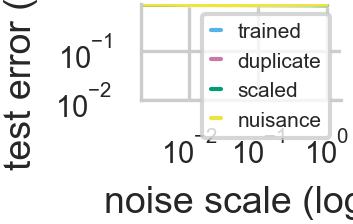

In [8]:
plt.figure(figsize=(1.6, 1.2))

# Task optimized model
mean_task = np.mean(task_optimized_model_robustness, axis=1)
std_task = np.std(task_optimized_model_robustness, axis=1)
plt.plot(noise_scales, mean_task, linewidth=1, label="trained")
plt.fill_between(noise_scales, mean_task - std_task, mean_task + std_task, alpha=0.2)

# Duplicated model
mean_dup = np.mean(duplicated_model_robustness, axis=1)
std_dup = np.std(duplicated_model_robustness, axis=1)
plt.plot(noise_scales, mean_dup, linewidth=1, label="duplicate")
plt.fill_between(noise_scales, mean_dup - std_dup, mean_dup + std_dup, alpha=0.2)

# Scaled model
mean_scaled = np.mean(scaled_model_robustness, axis=1)
std_scaled = np.std(scaled_model_robustness, axis=1)
plt.plot(noise_scales, mean_scaled, linewidth=1, label="scaled")
plt.fill_between(
    noise_scales, mean_scaled - std_scaled, mean_scaled + std_scaled, alpha=0.2
)

# Zeroed model
mean_zeroed = np.mean(zeroed_model_robustness, axis=1)
std_zeroed = np.std(zeroed_model_robustness, axis=1)
plt.plot(noise_scales, mean_zeroed, linewidth=1, label="nuisance")
plt.fill_between(
    noise_scales, mean_zeroed - std_zeroed, mean_zeroed + std_zeroed, alpha=0.2
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("noise scale (log)")
plt.ylabel("test error (log)")
plt.legend(handlelength=0.5, fontsize=5)


plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)


plt.xlim(left=2e-3)
plt.ylim(bottom=1e-2)
plt.tight_layout()
plt.savefig("param-noise.pdf", format="pdf", bbox_inches="tight", dpi=300)

### Transferability

In [9]:
def get_first_layer_preacts(model, inputs):
    return model.layers[0](inputs)


def get_first_layer_postacts(model, inputs):
    return model.activation(get_first_layer_preacts(model, inputs))


def get_second_layer_preacts(model, inputs):
    return model.layers[1](get_first_layer_postacts(model, inputs))


@partial(jax.vmap, in_axes=(None, 0))
def get_second_layer_postacts(model, inputs):
    return model.activation(get_second_layer_preacts(model, inputs))

In [6]:
def create_rotated_dataset(images, key):
    n = len(images)
    assert n % 4 == 0
    split_size = n // 4
    partitions = jnp.split(images[: split_size * 4], 4)

    rot_0 = partitions[0]  # no rotation
    rot_90 = jnp.rot90(partitions[1], k=1, axes=(1, 2))
    rot_180 = jnp.rot90(partitions[2], k=2, axes=(1, 2))
    rot_270 = jnp.rot90(partitions[3], k=3, axes=(1, 2))

    labels_0 = jnp.zeros(split_size, dtype=jnp.int32)
    labels_90 = jnp.ones(split_size, dtype=jnp.int32)
    labels_180 = jnp.full(split_size, 2, dtype=jnp.int32)
    labels_270 = jnp.full(split_size, 3, dtype=jnp.int32)

    all_images = jnp.concatenate([rot_0, rot_90, rot_180, rot_270])
    all_labels = jnp.concatenate([labels_0, labels_90, labels_180, labels_270])

    perm = jax.random.permutation(key, len(all_images))
    shuffled_images = all_images[perm]
    shuffled_labels = all_labels[perm]

    return shuffled_images, shuffled_labels


key = jax.random.PRNGKey(432)
rotated_images, rotation_labels = create_rotated_dataset(
    mnist_test_images.reshape(-1, 28, 28), key
)
rotated_images = rotated_images.reshape(-1, 28 * 28)
print(rotation_labels[:10])
rotation_labels = jax.nn.one_hot(rotation_labels, 4)
treescope.render_array(
    rotated_images.reshape(-1, 28, 28)[:10],
    pixels_per_cell=1,
    columns=[2, 0],
    axis_labels={0: "input example", 1: "input dimension", 2: "input dimension"},
    vmax=1,
    vmin=-1,
)

[0 1 1 2 1 2 2 0 2 0]


<Arrayviz rendering>

In [8]:
def create_coarse_grained_dataset(images, key):
    n = len(images)
    assert n % 4 == 0
    split_size = n // 4
    partitions = jnp.split(images[: split_size * 4], 4)

    rot_0 = partitions[0]  # no rotation
    rot_90 = jnp.rot90(partitions[1], k=1, axes=(1, 2))
    rot_180 = jnp.rot90(partitions[2], k=2, axes=(1, 2))
    rot_270 = jnp.rot90(partitions[3], k=3, axes=(1, 2))

    labels_0 = jnp.zeros(split_size, dtype=jnp.int32)
    labels_90 = jnp.ones(split_size, dtype=jnp.int32)
    labels_180 = jnp.full(split_size, 2, dtype=jnp.int32)
    labels_270 = jnp.full(split_size, 3, dtype=jnp.int32)

    all_images = jnp.concatenate([rot_0, rot_90, rot_180, rot_270])
    all_labels = jnp.concatenate([labels_0, labels_90, labels_180, labels_270])

    perm = jax.random.permutation(key, len(all_images))
    shuffled_images = all_images[perm]
    shuffled_labels = all_labels[perm]

    return shuffled_images, shuffled_labels

# re-classify 0 to 9 by their least prime factor (or 0 or 1)
coarse_labels =  {
    '0': '0',
    '1': '1',
    '2': '2',  # prime
    '3': '3',  # prime
    '4': '2',
    '5': '5',  # prime
    '6': '2',
    '7': '7',  # prime
    '8': '2',
    '9': '3',
}

key = jax.random.PRNGKey(432)
rotated_images, rotation_labels = create_rotated_dataset(
    mnist_test_images.reshape(-1, 28, 28), key
)
rotated_images = rotated_images.reshape(-1, 28 * 28)
print(rotation_labels[:10])
rotation_labels = jax.nn.one_hot(rotation_labels, 4)
treescope.render_array(
    rotated_images.reshape(-1, 28, 28)[:10],
    pixels_per_cell=1,
    columns=[2, 0],
    axis_labels={0: "input example", 1: "input dimension", 2: "input dimension"},
    vmax=1,
    vmin=-1,
)

SyntaxError: '{' was never closed (949043496.py, line 26)

In [11]:
from logistic import crossval_softmax_predict


def accuracy(pred_y, y):
    target_class = jnp.argmax(y, axis=1)
    predicted_class = jnp.argmax(pred_y, axis=1)
    return 1 - jnp.mean(predicted_class == target_class)


@partial(eqx.filter_vmap, in_axes=(eqx.if_array(0), None))
def transfer_err(model, sample_proportion):
    n = int(sample_proportion * len(rotated_images))
    activations = get_second_layer_postacts(model, rotated_images[:n])
    preds = crossval_softmax_predict(
        activations, rotation_labels[:n], num_splits=10, key=None
    )
    return accuracy(preds, rotation_labels[:n])


sample_proportions = tuple(map(float, np.arange(0.05, 1.05, 0.05)))
sample_sizes = tuple(map(lambda x: int(x * 10000), sample_proportions))
sample_sizes

(500,
 1000,
 1500,
 2000,
 2500,
 3000,
 3500,
 4000,
 4500,
 5000,
 5500,
 6000,
 6500,
 7000,
 7500,
 8000,
 8500,
 9000,
 9500,
 10000)

In [12]:
task_optimized_model_transferability = jnp.concatenate(
    tuple(transfer_err(mnist_model, prop)[None, :] for prop in sample_proportions),
    axis=0,
)

scaled_model_transferability = jnp.concatenate(
    tuple(
        transfer_err(scale_manipulation(mnist_model, 20), prop)[None, :]
        for prop in sample_proportions
    ),
    axis=0,
)

duplicated_model_transferability = jnp.concatenate(
    tuple(
        transfer_err(duplicate_type_manipulation(mnist_model, 1.2), prop)[None, :]
        for prop in sample_proportions
    ),
    axis=0,
)

zeroed_model_transferability = jnp.concatenate(
    tuple(
        transfer_err(
            zero_type_manipulation(
                mnist_model, 1 * 128, jax.random.split(key, num_seeds)
            ),
            prop,
        )[None, :]
        for prop in sample_proportions
    ),
    axis=0,
)

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(1.6, 1.2))

# Task optimized model
mean_task = np.mean(task_optimized_model_transferability, axis=1)
std_task = np.std(task_optimized_model_transferability, axis=1)
plt.plot(sample_sizes, mean_task, linewidth=1, label="trained")
plt.fill_between(sample_sizes, mean_task - std_task, mean_task + std_task, alpha=0.2)

# Duplicated model
mean_dup = np.mean(duplicated_model_transferability, axis=1)
std_dup = np.std(duplicated_model_transferability, axis=1)
plt.plot(sample_sizes, mean_dup, linewidth=1, label="duplicate")
plt.fill_between(sample_sizes, mean_dup - std_dup, mean_dup + std_dup, alpha=0.2)

# Scaled model
mean_scaled = np.mean(scaled_model_transferability, axis=1)
std_scaled = np.std(scaled_model_transferability, axis=1)
plt.plot(sample_sizes, mean_scaled, linewidth=1, label="scaled")
plt.fill_between(
    sample_sizes, mean_scaled - std_scaled, mean_scaled + std_scaled, alpha=0.2
)

# Zeroed model
mean_zeroed = np.mean(zeroed_model_transferability, axis=1)
std_zeroed = np.std(zeroed_model_transferability, axis=1)
plt.plot(sample_sizes, mean_zeroed, linewidth=1, label="nuisance")
plt.fill_between(
    sample_sizes, mean_zeroed - std_zeroed, mean_zeroed + std_zeroed, alpha=0.2
)

plt.xscale("log")
plt.xlabel("sample budget (log)")
plt.ylabel("transfer error")
plt.legend(handlelength=0.5, fontsize=5, ncol=2)  # , bbox_to_anchor=(0.1, 0.65))

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.xlim(left=1000, right=10000)
plt.ylim(bottom=0.0, top=1.0)
plt.tight_layout()
plt.savefig("transfer.pdf", format="pdf", bbox_inches="tight", dpi=300)